# GLRT CI Coverage

In [1]:
# Comparing the analytic GLRT for the single-coefficient case with the optimization-based version
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
from uncertainty.DataGeneration import linearRegression_normal
from uncertainty.torch_linear import TorchLinear
from uncertainty.analyticLinearRegressionCIs import analyticLinearTest_GLRT, analyticLinearCis
from uncertainty.glrtTorch import glrtTorchCis
from uncertainty.torch_linear import TorchLinear

In [3]:
def compareAnalyticVsOptimization(beta, n=200, alpha=0.05):
    """Generate data according to a linear regression with coefficient vector beta.
    Compute the analytic chi-squared test 'is the coefficient vector zero?'. Record the p-value.
    Compute the confidence intervals on beta using the GLRT-based method. Record whether ALL intervals contains zero.
    Return TRUE if both methods agree, and FALSE otherwise."""  
    # Get data
    X, y = linearRegression_normal(beta=np.array(beta), cov=np.eye(len(beta)), sigma=1, n=n)

    # Compute the p-value from the chi squared test
    TL = TorchLinear(lr=0.3,max_iter=30)
    TL.fit(X,y)
    pVal_TL = analyticLinearTest_GLRT(TL, X, y)
    
    # Next, get the optimization-based intervals.
    # GLRT method with Torch model (coefs)
    lcb_GLRT, ucb_GLRT, lcb_Results, ucb_Results, ucb_Torch = glrtTorchCis(
        lambda:TorchLinear(lr=0.3,max_iter=100,fit_intercept=False), X=X, y=y, citype='coefs', alpha=alpha,
        search_kwargs={'lmbds':np.logspace(-10,10,101)},fit_kwargs={'lr':0.3,'max_iter':30})
    
    # To check whether they agree with the analytic version:
    # The p-value should be < 0.05 iff any of the level-0.05 glrt-based confidence intervals
    # on the coefficient beta don't contain zero.
    isNotZero_analytic = pVal_TL < alpha    # The chi-square test is one-sided
    isNotZero_optim = any(lcb_GLRT > 0) or any(ucb_GLRT < 0)
    
    print("p value", pVal_TL, "and confidence interval(s)", lcb_GLRT, "to", ucb_GLRT)
    
    return (isNotZero_analytic == isNotZero_optim, pVal_TL, lcb_GLRT, ucb_GLRT)
    

## Single nonzero coefficient

In [6]:
%%time
bmean, bstd = 0,1
reps = 100

equiv = []
pVals = []
lcbs = []
ucbs = []

betas = []
covered = []

#for i in range(1000):
for i in range(reps):
    beta = np.random.normal(loc=bmean,scale=bstd)
    s, p, l, u = compareAnalyticVsOptimization(beta=[beta])
    equiv.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)
    
    betas.append(beta)
    covered.append(l[0]<=beta<=u[0])

p value 0.0 and confidence interval(s) [-0.86222976] to [-0.61519784]
p value 1.0845657705260692e-11 and confidence interval(s) [-0.60028249] to [-0.40164489]
p value 0.0 and confidence interval(s) [0.52330929] to [0.75474006]
p value 0.0 and confidence interval(s) [0.79240674] to [1.03448117]
CPU times: user 2min 44s, sys: 513 ms, total: 2min 44s
Wall time: 2min 44s


In [8]:
print(f'Coverage: {np.mean(covered)}')

Coverage: 0.92


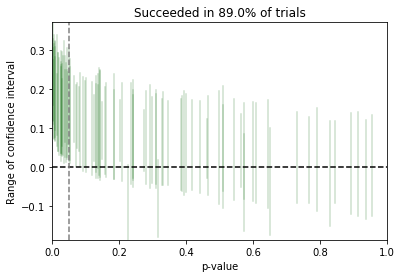

In [5]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Single Zero Coefficient

In [6]:
%%time
beta = 0.0

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s[0])
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.010065697013278752 and confidence interval [-0.32121551] to [-0.05462781]
p value 0.38332014773572665 and confidence interval [-0.18513457] to [0.0566593]
p value 0.46933716149415605 and confidence interval [-0.17649673] to [0.07245571]
p value 0.40162140227533727 and confidence interval [-0.06663625] to [0.17793277]
p value 0.13307229248481245 and confidence interval [-0.01165634] to [0.20390682]
p value 0.9251746992055117 and confidence interval [-0.09618982] to [0.08314887]
p value 0.9492197278954458 and confidence interval [-0.13533084] to [0.14375989]
p value 0.6220876893032526 and confidence interval [-0.17182997] to [0.1003686]
p value 0.2971460329040737 and confidence interval [-0.05243973] to [0.20746814]
p value 0.7509762379159894 and confidence interval [-0.15082262] to [0.10511569]
p value 0.8686630493086943 and confidence interval [-0.1364222] to [0.11374637]
p value 0.12406568351362302 and confidence interval [-0.19133796] to [-0.02761748]
p value 0.694166183241

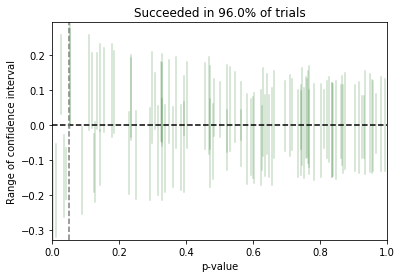

In [7]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Multidimensional Zero Coefficient

In [ ]:
#%%time
bmean, bstd = 0,0
reps = 1000

for d in [2, 5, 10]:
    if d == 1:
        print("We don't allow d=1 because it changes the return type of the subplots function >.<")
    equiv = []
    pVals = []
    lcbs = []
    ucbs = []

    betas = []
    covered = []

    for i in range(reps):
        beta = np.array(np.random.normal(loc=bmean,scale=bstd, size=d))
        s, p, l, u = compareAnalyticVsOptimization(beta=beta)
        equiv.append(s)
        pVals.append(p)
        lcbs.append(l)
        ucbs.append(u)

        betas.append(beta)
        covered.append((l<=beta) & (beta<=u))
    
    fig, ax = plt.subplots(d, figsize=(8, 4*d))
    for i in range(d):
        ilcbs = [l[i] for l in lcbs]
        iucbs = [u[i] for u in ucbs]
        minY = min(ilcbs)
        maxY = max(iucbs)
        ax[i].set_ylim(minY, maxY)

        for (p, l, u, s) in zip(pVals, ilcbs, iucbs, equiv):
            # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
            ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                        color=('darkgreen' if s else 'darkred'), alpha=(0.2 if s else 1))  # display mismatches in a darker line

        ax[i].axhline(0, color='k', linestyle='--')
        ax[i].axvline(0.05, color='gray', linestyle='--')

    ax[0].set_title("Analytic agreed with empirical in " + str(np.mean(equiv)*100) + "% of trials\nwith empirical coverage "+str(np.mean(covered)*100)+"%")    
    ax[d-1].set_xlabel("p-value")
    ax[0].set_ylabel("Range of confidence interval")
    plt.tight_layout()
    
    plt.savefig("trueZero-dim"+str(d)+".png")
    plt.show()

p value 0.6980530294878315 and confidence interval(s) [-0.10692994 -0.07727333] to [0.14759281 0.19240353]
p value 0.3347537088042244 and confidence interval(s) [-0.1298134 -0.2003977] to [0.16555354 0.03208879]
p value 0.8983883131102209 and confidence interval(s) [-0.17557962 -0.13043852] to [0.10444842 0.11353017]
p value 0.023982881216893293 and confidence interval(s) [ 0.06327499 -0.20939884] to [0.31963354 0.0639657 ]
p value 0.5277879658264382 and confidence interval(s) [-0.17331238 -0.24415238] to [0.16612533 0.06457992]
p value 0.896604154356702 and confidence interval(s) [-0.1350904  -0.15964858] to [0.12019322 0.08782809]
p value 0.4855059501679706 and confidence interval(s) [-0.08198623 -0.20615888] to [0.15843178 0.04944496]


## Multidimensional Nonzero Coefficient

In [ ]:
%%time
bmean, bstd = 0,1
reps = 1000

for d in [2, 5, 10]:
    if d == 1:
        print("We don't allow d=1 because it changes the return type of the subplots function >.<")
    equiv = []
    pVals = []
    lcbs = []
    ucbs = []

    betas = []
    covered = []

    for i in range(reps):
        beta = np.array(np.random.normal(loc=bmean,scale=bstd, size=d))
        s, p, l, u = compareAnalyticVsOptimization(beta=beta)
        equiv.append(s)
        pVals.append(p)
        lcbs.append(l)
        ucbs.append(u)

        betas.append(beta)
        covered.append((l<=beta) & (beta<=u))
    
    fig, ax = plt.subplots(d, figsize=(8, 4*d))
    for i in range(d):
        ilcbs = [l[i] for l in lcbs]
        iucbs = [u[i] for u in ucbs]
        minY = min(ilcbs)
        maxY = max(iucbs)
        # For some reason this isn't working?
        ax[i].set_ylim(minY, maxY)

        for (p, l, u, s) in zip(pVals, ilcbs, iucbs, equiv):
            # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
            ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                        color=('darkgreen' if s else 'darkred'), alpha=(0.2 if s else 1))  # display mismatches in a darker line

        ax[i].axhline(0, color='k', linestyle='--')
        ax[i].axvline(0.05, color='gray', linestyle='--')

    ax[0].set_title("Analytic agreed with empirical in " + str(np.mean(equiv)*100) + "% of trials\nwith empirical coverage "+str(np.mean(covered)*100)+"%")    
    ax[d-1].set_xlabel("p-value")
    ax[0].set_ylabel("Range of confidence interval")
    plt.tight_layout()
    
    plt.savefig("trueNonZero-dim"+str(d)+".png")
    plt.show()